In [279]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [280]:
df = pd.read_csv("../data/marketing_campaign.csv", sep="\t")
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [281]:
print(df.columns)

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'],
      dtype='object')


In [282]:
# 1. 결측치 확인 및 처리
print(df.isnull().sum())
df = df.dropna() 

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64


In [283]:
### 2. Stratified Samlpling
from sklearn.model_selection import train_test_split
df_stratified, _ = train_test_split(df, test_size=0.7, stratify=df["Response"], random_state=42)

### 3. Binning (Income)
df["Income_eq_width"] = pd.cut(df["Income"], bins=3, labels=["Low", "Medium", "High"])
df["Income_eq_freq"] = pd.qcut(df["Income"], q=3, labels=["Low", "Medium", "High"])

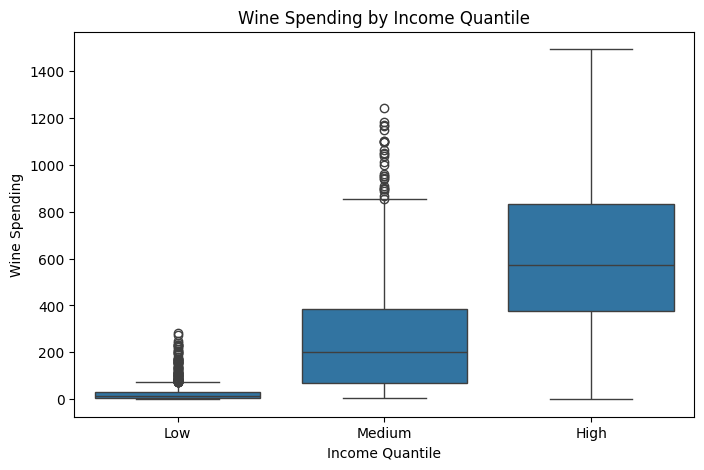

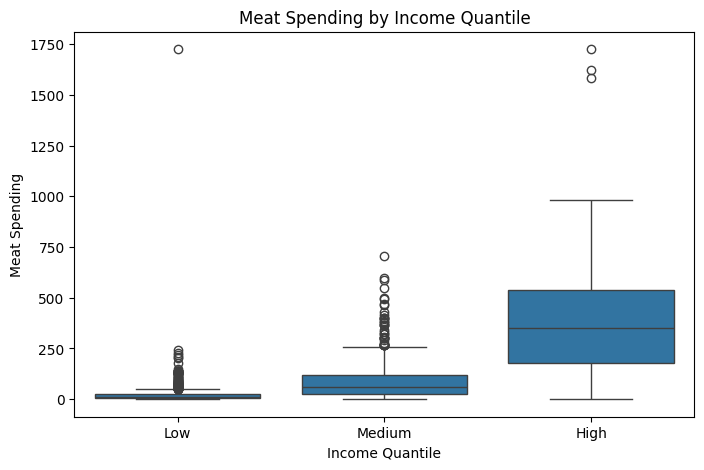

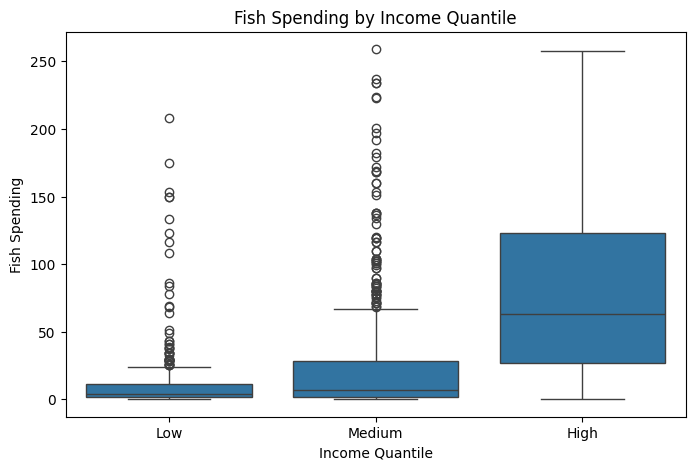

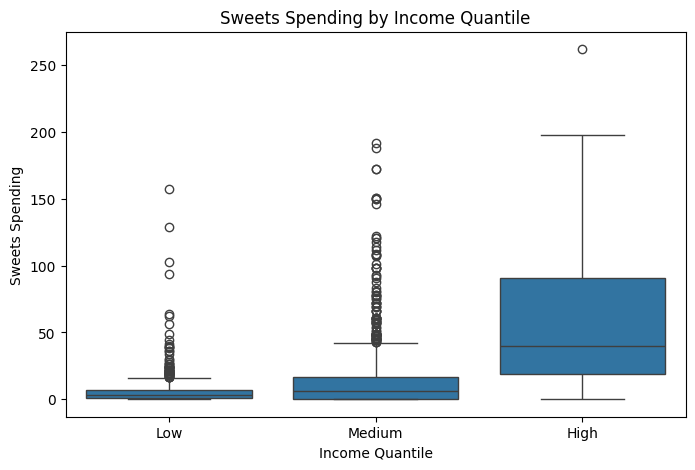

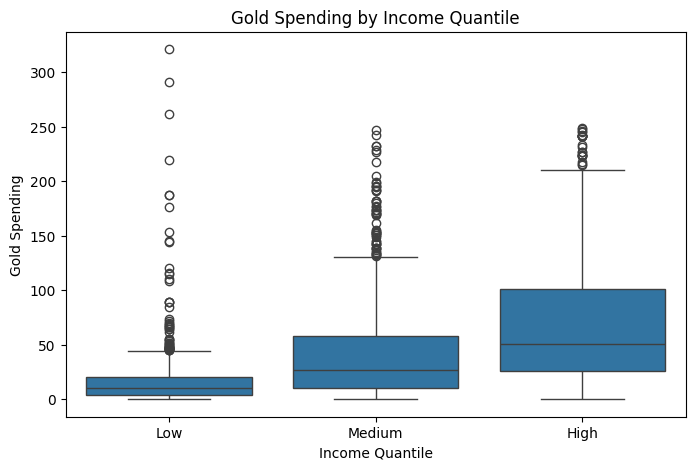

In [284]:
# 4. 시각화: 소득 구간 vs 품목들 소비 비교
product_cols = [
    ("MntWines", "Wine"), # 와인
    ("MntMeatProducts", "Meat"), # 육류
    ("MntFishProducts", "Fish"), # 웰빙
    ("MntSweetProducts", "Sweets"), # 디저트
    ("MntGoldProds", "Gold") # 금
]

for col, label in product_cols:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x="Income_eq_freq", y=col, data=df)
    plt.title(f"{label} Spending by Income Quantile")
    plt.xlabel("Income Quantile")
    plt.ylabel(f"{label} Spending")
    plt.show()


In [285]:
# 5. 이상치 제거
## 5-1. 생년 이상치 제거거
df = df[(df["Year_Birth"] >= 1900) & (df["Year_Birth"] <= 2005)]

# 5-2. IQR 이상치 필터
for col in [
    "Income", "MntWines", "MntMeatProducts", "MntFishProducts", "MntSweetProducts", "MntGoldProds",
    "NumDealsPurchases", "NumWebPurchases", "NumCatalogPurchases", "NumStorePurchases", "NumWebVisitsMonth"
]:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    df = df[(df[col] >= Q1 - 1.5 * IQR) & (df[col] <= Q3 + 1.5 * IQR)]

In [286]:
# 6. 범주형 변수 변환
df["Education"] = df["Education"].astype("category")
df["Marital_Status"] = df["Marital_Status"].astype("category")

# 6. 날짜 처리 및 연/월 추출
df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"], dayfirst=True)
df["Customer_Year"] = df["Dt_Customer"].dt.year
df["Customer_Month"] = df["Dt_Customer"].dt.month
df.drop(columns=["Dt_Customer"], inplace=True)

In [287]:
# 7. one-hot encoding + 스케일링
df_encoded = pd.get_dummies(df, drop_first=True)
scaler = StandardScaler()
numerical_cols = df_encoded.select_dtypes(include=["number"]).columns.tolist()
df_encoded[numerical_cols] = scaler.fit_transform(df_encoded[numerical_cols])

In [288]:
# 8. 결과 저장 및 확인
df_encoded.to_csv("../data/cleaned_marketing_campaign.csv", index=False)
df_encoded

,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,Education_PhD,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow,Income_eq_width_Medium,Income_eq_width_High,Income_eq_freq_Medium,Income_eq_freq_High
1,-1.045562,-1.527232,0.961052,0.434607,0.980811,-0.391789,-0.554261,-0.532927,-0.681396,-0.516686,...,False,False,False,True,False,False,False,False,True,False
3,0.188411,1.145447,-0.667314,0.434607,-0.903179,-0.805732,-0.554261,-0.095417,-0.094755,0.429660,...,False,False,False,False,True,False,False,False,False,False
7,0.186871,1.234536,-0.104520,0.434607,-0.903179,-0.598761,0.576482,0.779604,1.413749,-0.398393,...,True,False,True,False,False,False,False,False,False,False
8,-0.220143,0.254554,-0.361035,0.434607,-0.903179,-1.047199,-0.502073,-0.678764,0.072856,-0.398393,...,True,False,False,False,True,False,False,False,False,False
11,-1.595739,0.432732,-2.250049,-1.595599,-0.903179,0.332610,-0.641241,1.654625,-0.471881,0.547954,...,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2229,1.389748,0.076375,-0.850173,2.464813,-0.903179,-1.392151,-0.693429,-0.387090,-0.597590,1.612594,...,False,False,True,False,False,False,False,False,False,False
2230,0.441486,1.145447,-1.959724,0.434607,-0.903179,1.126000,-0.328112,-0.241254,0.156662,0.074780,...,False,False,False,True,False,False,False,False,False,False
2232,0.772762,1.323625,-0.653261,-1.595599,-0.903179,0.022153,-0.658637,-0.532927,-0.681396,-0.398393,...,False,False,False,True,False,False,False,False,False,False
2234,0.862662,0.254554,-0.024582,0.434607,-0.903179,1.091505,-0.693429,-0.241254,-0.639493,-0.043513,...,False,False,True,False,False,False,False,False,False,False


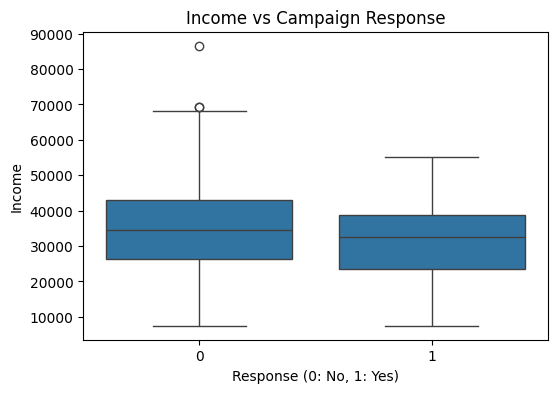

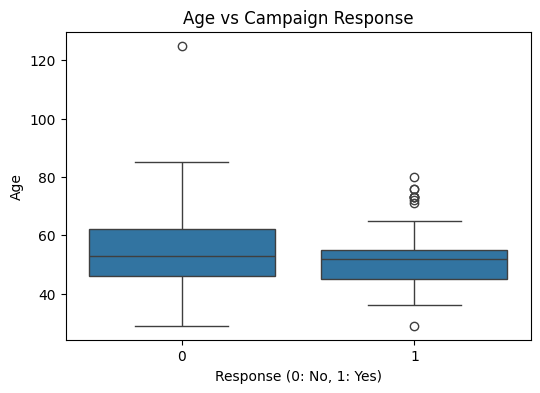

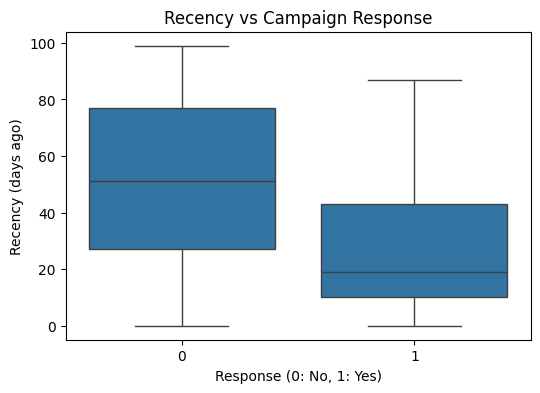

In [289]:
# 1-1. 소득에 따른 구매 반응
plt.figure(figsize=(6, 4))
sns.boxplot(x="Response", y="Income", data=df)
plt.title("Income vs Campaign Response")
plt.xlabel("Response (0: No, 1: Yes)")
plt.ylabel("Income")
plt.show()

# 1-2. 나이에 따른 구매 반응
df["Age"] = 2025 - df["Year_Birth"]
plt.figure(figsize=(6, 4))
sns.boxplot(x="Response", y="Age", data=df)
plt.title("Age vs Campaign Response")
plt.xlabel("Response (0: No, 1: Yes)")
plt.ylabel("Age")
plt.show()

# 1-3. Recency (최근 구매일) vs 반응
plt.figure(figsize=(6, 4))
sns.boxplot(x="Response", y="Recency", data=df)
plt.title("Recency vs Campaign Response")
plt.xlabel("Response (0: No, 1: Yes)")
plt.ylabel("Recency (days ago)")
plt.show()

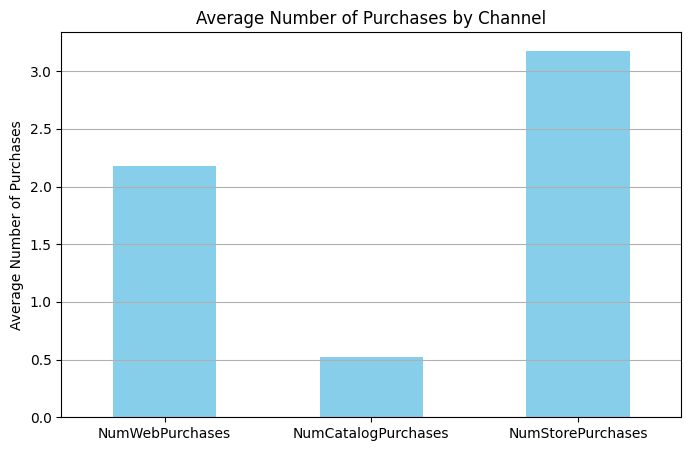

In [290]:
channel_cols = ["NumWebPurchases", "NumCatalogPurchases", "NumStorePurchases"]

plt.figure(figsize=(8, 5))
df[channel_cols].mean().plot(kind='bar', color='skyblue')
plt.title("Average Number of Purchases by Channel")
plt.ylabel("Average Number of Purchases")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()


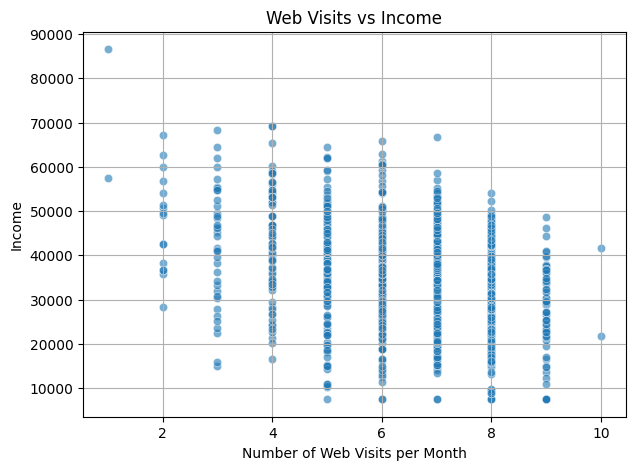

In [ ]:
# 웹 방문 횟수 vs 소득 (상관관계)
plt.figure(figsize=(7, 5))
sns.scatterplot(x="NumWebVisitsMonth", y="Income", data=df, alpha=0.6)
plt.title("Web Visits vs Income")
plt.xlabel("Number of Web Visits per Month")
plt.ylabel("Income")
plt.grid(True)
plt.show()
